# Solución Tarea
Espacio para desarrollar la tarea propuesta sobre la fase de entendimiento de datos grupal sobre las tablas PIBCopia y divipolaCopia

### Perfilamiento de datos

## Introducción
    
    Al desarrollar esta tarea, se busca comprender la fase de entendimiento de datos de la metodología ASUM-DM para la empresa WWImporters, para esto, se realizará un perfilamiento general, análisis de reglas de negocio, estadísticos y análisis de calidad de datos sobre las tablas PIBCopia y divipolaCopia.
    
    La fase de entendimiento de datos es fundamental ya que nos permite familiarizarnos con los datos de la organización, sus relaciones, determinar en primera medida la viabilidad de realizar un proyecto de analítica dada la información suministrada, determinar si los datos son suficientes y las acciones de mejora que se pueden realizar para obtener resultados confiables, además, nos permite identificar nuevas oportunidades de analítica.

### Configuración e importe de paquetes

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuración del controlador e inicio de sesion Spark

In [2]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [3]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [4]:
# Conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.116:8080/ProyectoTransaccional'
db_user = ''
db_psswd = ''

PATH='./'

### Perfilamiento de datos
Esta primera sección de perfilamiento de datos se centrará en tres aspectos fundamentales que son  **entendimiento general** que hace referencia a tener una comprensiòn global antes de entrar en los detalles de los datos compartidos, validación de **reglas de negocio** que corresponden a especificaciones dadas por el negocio en relación con los datos y **análisis descriptivo** en donde se revisan estadísticas como mínimo, máximo, media, mediana, distribuciones de los datos, valores nulos, cardinalidad con el fin de comprender en mayor nivel de profundidad los datos compartidos y diagramas para la visualización de los datos. El **análisis de calidad** se abordará en una sección posterior.

### Información dada por la organización relacionada con los datos

Para este estudio y entendimiento de datos, el enfoque estará sobre el análisis de los datos de las tablas PIBCopia y divipolaCopia, en donde se encuentra registrados los PIB de cada departamento en determinados años y la información de centros poblados respectivamente. El pib es un indicador que ofrece información sobre el tamaño de la economía y su desempeño. Los centros poblados son la concentración de mínimo 20 viviendas contiguas.

En relación a los datos Wide World Importers menciona:

1. Hay informacion del PIB para los 32 departamentos desde 2005 hasta 2018
2. Se tiene la información de proyecciones de vida por género y edad para los 32 departamentos desde 2005 hasta 2015
3. El total de hombres de valle del cauca para 2014 es 2110069
4. Hay información de 605.448 vuelos entre 2004 y 2018 y de 865 aeropuertos construidos desde 2013 hasta 2020
5. Hay información de 7879 centros poblados

Para la fase de entendimiento de datos se tendrá en cuenta el punto 1 y 5 principalmente en este notebook.

### Conexión a fuente de datos y acceso a los datos

#### Conexión a fuente de datos
A continuación se define una función que permite establecer la conexión a la base de datos, para el esquema **ProyectoTransaccional** con el fin de analizar la información contenida especialmente en las tablas **divipolaCopia** y **PIBCopia**

In [5]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

#### Cargue de datos
Para consultar desde la base de datos se va a acceder directamente a la tabla dado su nombre WWImportersTransactional.movimientosCopia

In [6]:
sql_pib = 'ProyectoTransaccional.PIBCopia'
sql_divipola = 'ProyectoTransaccional.divipolaCopia'

In [7]:
pib = obtener_dataframe_de_bd(db_connection_string, sql_pib, db_user, db_psswd)
divipola = obtener_dataframe_de_bd(db_connection_string, sql_divipola, db_user, db_psswd)

### Entendimiento general de datos

Se mostrarán las primeras 10 filas que están presentes en la tabla PIBCopia para ver la información y estructura.

In [9]:
pib.show(10)

+----------------------------+--------------------+-------+--------+--------------------+--------------------+--------+--------+--------------------+--------+
|CodigoDepartamento(DIVIPOLA)|       DEPARTAMENTOS|   2006|    2007|                2008|                2010|    2011|    2012|                2013|    2014|
+----------------------------+--------------------+-------+--------+--------------------+--------------------+--------+--------+--------------------+--------+
|                          41|                uila|6895658| 7441987|   8686536.103258422|    9548624.85406653|11113741|11400169|1.1967750469189592E7|12755711|
|                          18|            CaquetÃ¡|3575615| 4060678|   4519574.129383702|   5048396.606737779| 5516404| 6476778|    7161524.44383983| 7990249|
|                           8|          AtlÃ¡ntico|7194985| 8299825|   8858405.054387597|   9481200.322350295|10288314|11421539|1.2434114309437651E7|13681473|
|                          63|            Quin

Se mostrarán las primeras 10 filas que están presentes en la tabla divipolaCopia para ver la información y estructura.

In [8]:
divipola.show(10)

+-------------------+----------------+---------------------+-------------------+----------------+---------------------+-------------------+--------------+--------------+---------------+----------------------------------------+-------------------------+
|Código Departamento|Código Municipio|Código Centro Poblado|Nombre Departamento|Nombre Municipio|Nombre Centro Poblado|Tipo Centro Poblado|      Longitud|       Latitud|Nombre Distrito|Municipio/Áreas No Municipalizadas (ANM)|Nombre Área Metropolitana|
+-------------------+----------------+---------------------+-------------------+----------------+---------------------+-------------------+--------------+--------------+---------------+----------------------------------------+-------------------------+
|                 41|           91001|             91001033|           amazonas|           NEIVA| COMUNIDAD INDÍGEN...|     CENTRO POBLADO|-70.0285785394|-4.11198257304|               |                               MUNICIPIO|               

Según la información que se presenta en la tabla **PIBCopia**, se puede observar que en los registros tenemos información relacionada al **código del departamento** (que guarda relación con la tabla divipolaCopia), **departamentos**, y el **PIB para los años 2006, 2007, 2008, 2010, 2011, 2012, 2013 y 2014**. Esto muestra que no se están incluyendo todos los años comprendidos desde el 2005 hasta el 2018. En esta tabla lo ideal es que la información de PIB se de por departamento, de tal forma que si busco por un nombre de departamento en específico, se pueda obtener un único registro con la información del PIB. <br>
Por otra parte, se presenta la tabla **divipolaCopia** la cual almacena información de los centros poblacionales, en la información que almacena se puede evidenciar que el identificador de la tabla es **Código Centro Poblado**, también se presenta información asociada al municipio en las columas **Código Municipio y Nombre Municipio**, se muestra información más específica para la localización como la **Longitud y la Latitud**, el **tipo de centro poblado**, el **nombre del distrito** y el **área metropolitana**.

In [10]:
pib.schema

StructType(List(StructField(CodigoDepartamento(DIVIPOLA),LongType,true),StructField(DEPARTAMENTOS,StringType,true),StructField(2006,LongType,true),StructField(2007,LongType,true),StructField(2008,DoubleType,true),StructField(2010,DoubleType,true),StructField(2011,LongType,true),StructField(2012,LongType,true),StructField(2013,DoubleType,true),StructField(2014,LongType,true)))

Con la ejecución del esquema para la tabla PIBCopia se puede observar que hay tipos de datos que no corresponden, por ejemplo, hay años como el 2006 que el tipo es un LongType y otros años como el 2010 que el tipo es DoubleType, resulta extraño que según un año, el tipo de dato del PIB varíe.

In [11]:
divipola.schema

StructType(List(StructField(Código Departamento,IntegerType,true),StructField(Código Municipio,IntegerType,true),StructField(Código Centro Poblado,IntegerType,true),StructField(Nombre Departamento,StringType,true),StructField(Nombre Municipio,StringType,true),StructField(Nombre Centro Poblado,StringType,true),StructField(Tipo Centro Poblado,StringType,true),StructField(Longitud,DoubleType,true),StructField(Latitud,DoubleType,true),StructField(Nombre Distrito,StringType,true),StructField(Municipio/Áreas No Municipalizadas (ANM),StringType,true),StructField(Nombre Área Metropolitana,StringType,true)))

Con la ejecución del esquema para la tabla divipolaCopia se puede observar en primera medida que el tipo de dato del campo Código Departamento es IntegerType y para el campo de la tabla pibCopia es LongType, por otra parte, los campos Código Departamento, Código Municipio y Código Centro Poblado son de tipo Integer, los campos Longitud y Latitud son de tipo Double y el resto de campos son String, mayoritariamente hay más campos de tipo String.

**¿Qué es una fila de la fuente compartida para la tabla PIBCopia?**
Con los análisis antes mencionados, se puede concluir que una fila de la tabla PIBCopia corresponde al PIB por departamento en un año en específico.<br>
**¿Qué es una fila de la fuente compartida para la tabla divipolaCopia?**
Con los análisis antes mencionados, se puede concluir que una fila de la tabla divipolaCopia corresponde a la información de centros poblados que están relacionados con un departamento y ciudad, además, relaciona información de ubicación más específica como la longitud y latitud.

Una vez entendida en términos generales la estructura de los datos, es necesario conocer la cantidad de datos disponibles, esto se hace con count() y con columns, que retornan el número de filas y número de columnas respectivamente.

In [12]:
print((pib.count(), len(pib.columns)))

(27, 10)


In [13]:
print((divipola.count(), len(divipola.columns)))

(9508, 12)


**¿Cuantos datos nos compartieron para el proyecto?** <br>
**PIBCopia** <br>
En total tenemos 27 registros de pib relacionados a cada departamento y tenemos en total 10 variables a revisar asociadas a los pibs de las cuales 9 son nùmericas, de esta 9, 8 son columnas de años y 1 columna está asociada con el código del departamento, existe otra columna de tipo cadena de caracteres que permite identificar el nombre del departamento. <br>
**divipolaCopia** <br>
En total hay 9508 registros de centros poblados, existen 12 variables asociadas a los centros poblados de las cuales 5 representan valores numéricos que representan los diferentes códigos y localización y 7 valriables son de tipo cadena de caracteres para identificar los nombres de departamentos, ciudades, áreas y tipos de centros poblados.

### Revisión de reglas de negocio 
Se confirmarán las reglas de negocio que se han suministrado por parte de Wide World Importers <br>
**NOTA** Tener en cuenta que se consideran las reglas de negocio 1 y 5 como se muestra a continuación
#### 1. Hay informacion del PIB para los 32 departamentos desde 2005 hasta 2018
Como primera medida, se valida que existan los 32 departamentos en la tabla PIBCopia

In [14]:
pib.select("DEPARTAMENTOS").distinct().count()

17

Podemos apreciar que existe registro del PIB solo para 17 departamentos, que corresponde a casi la mitad de lo que indica la regla de negocio, por lo que es necesario pedirle una aclaración al negocio sobre la falta de departamentos

Como segunda medida, se procede a verificar que efectivamente se estén incluyendo los años desde el 2005 hasta el 2018, para esto, se muestran las columnas de la tabla

In [16]:
pib.columns

['CodigoDepartamento(DIVIPOLA)',
 'DEPARTAMENTOS',
 '2006',
 '2007',
 '2008',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014']

Como se puede observar, no existe información del PIB para el año 2005, 2009, 2015, 2016, 2017 y 2018, lo cual corresponde a casi el 43% de años faltantes, es una cantidad considerable así que es indispensable corroborar la información con negocio

#### 5. Hay información de 7879 centros poblados
Se procede a evaluar la cantidad de centros poblados que existen en la tabla divipolaCopia

In [21]:
divipola.count()

9508

Vemos que existen 9508 registros de centros poblados, existen 1629 registros de más, esto corresponde a un 21% de información adicional, se puede indagar más sobre el por qué existen más registros, para esto, se procede a contar la cantidad de registros diferentes en la taba

In [22]:
divipola.distinct().count()

9508

La cantidad de registros diferentes es igual a la cantidad total de registros, entonces, ¿Qué otra razón puede existir para que exista esta diferencia de registros? esto se puede deber a que existen valores en la columna identificadora repetidos, pero que el resto de atributos son diferentes, vamos a verlos

In [25]:
divipola.select("Código Centro Poblado").distinct().count()

7879

Esto nos muestra que tenemos 1629 registros el mismo centro poblado pero con valores diferentes

### Análisis descriptivo
Una vez cubierto lo básico de reglas de negocio, se realizará el perfilamiento estadístico. Para ver estadisticos generales como conteo, mínimo, máximo, desviación estandar y percentiles.
#### Análisis para PIBCopia

In [26]:
pib.summary().show()

+-------+----------------------------+-------------+------------------+-----------------+-------------------+--------------------+-----------------+--------------------+--------------------+--------------------+
|summary|CodigoDepartamento(DIVIPOLA)|DEPARTAMENTOS|              2006|             2007|               2008|                2010|             2011|                2012|                2013|                2014|
+-------+----------------------------+-------------+------------------+-----------------+-------------------+--------------------+-----------------+--------------------+--------------------+--------------------+
|  count|                          27|           27|                27|               27|                 27|                  27|               27|                  27|                  27|                  27|
|   mean|            48.7037037037037|         null| 6413240.740740741|7130828.037037037|  7851694.186446355|   8737185.290427044|9728735.962962963|1.03

En el conteo vemos que ninguna columna da como resultado 0, por el contrario, todas dan como resultado 27, esto resulta interesante, ya que todas las columnas podrían contener valores nulos, sin embargo, acá se evidencia que todas las filas tienen asignado un valor a cada columna. Para el campo CodigoDepartamento se calcula la media, pero este valor no es relevante, por lo que no se considera, por otra parte, para cada años se muestra la media, acá podemos ver que para el año 2006 se tuvo un PIB promedio de 6413240.740740741, mientras que para el años 2014 se tuvo un PIB promedio de 1.1774719888888888E7, esto da una diferencia de 5361479.148 entre el año 2006 y el 2014, también se pueden ver los PIB mínimos y máximos por años, para el 2006 se tuvo un PIB mínimo de 3575615 y un PIB mínimo para el año 2014 de 4733848. Por último, el 75% de los datos para el año 2006 no supera el PIB 8046451, mientras que el 75% de los datos para el año 2014 no supera el PIB 16490649.

#### Análisis para divipolaCopia

In [27]:
divipola.summary().show()

+-------+-------------------+------------------+---------------------+-------------------+----------------+---------------------+-------------------+------------------+------------------+--------------------+----------------------------------------+-------------------------+
|summary|Código Departamento|  Código Municipio|Código Centro Poblado|Nombre Departamento|Nombre Municipio|Nombre Centro Poblado|Tipo Centro Poblado|          Longitud|           Latitud|     Nombre Distrito|Municipio/Áreas No Municipalizadas (ANM)|Nombre Área Metropolitana|
+-------+-------------------+------------------+---------------------+-------------------+----------------+---------------------+-------------------+------------------+------------------+--------------------+----------------------------------------+-------------------------+
|  count|               9508|              9508|                 9508|               9508|            9508|                 9508|               9508|              9508|    

En el conteo vemos que ninguna columna da como resultado 0, por el contrario, todas dan como resultado 9508, esto resulta interesante, ya que todas las columnas podrían contener valores nulos, sin embargo, acá se evidencia que todas las filas tienen asignado un valor a cada columna. También se puede evidenciar medidas importantes como la longitud mínima que corresponde a -81.7300009044 y latitud mínima de -4.19469878932, por otra parte, el 75% de los datos no superan la Longitud -73.5653004569 y para la Latitud el 75% de los datos no superan una latitud de  8.55580584876. Por último, vale la pena observar que el nombre de departamento con caracteres mínimos es ANTIOQUIA y vichada es el que tiene los caracteres máximos.

A continuación se mostrará un diagrama de caja con el fin de detectar valores atípicos en los años que registran PIB
#### 2006

{'whiskers': [<matplotlib.lines.Line2D at 0x1c2d6340708>,
 'caps': [<matplotlib.lines.Line2D at 0x1c2d632fb48>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c2d52da188>],
 'medians': [<matplotlib.lines.Line2D at 0x1c2d6353188>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c2d634db48>],
 'means': []}

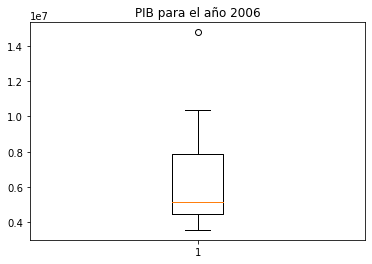

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('PIB para el año 2006')
ax1.boxplot(np.array(pib.select('2006').collect()))

Acá se logra apreciar que el 75% de los datos muestra un valor de PIB hasta el 0.8e7 y se registra un valor atípico de PIB superior a 1.4e7

#### 2007

{'whiskers': [<matplotlib.lines.Line2D at 0x1c2d6459148>,
 'caps': [<matplotlib.lines.Line2D at 0x1c2d6459948>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c2d6457808>],
 'medians': [<matplotlib.lines.Line2D at 0x1c2d6460788>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c2d6460e48>],
 'means': []}

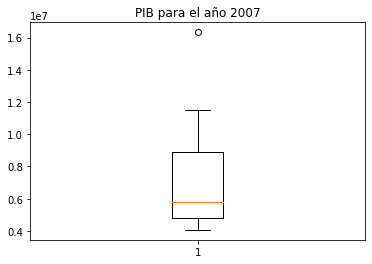

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('PIB para el año 2007')
ax1.boxplot(np.array(pib.select('2007').collect()))

Acá se logra apreciar que el 75% de los datos muestra un valor de PIB alrededor de el 0.9e7 y se registra un valor atípico de PIB superior a 1.6e7

#### 2008

{'whiskers': [<matplotlib.lines.Line2D at 0x1c2d64dd208>,
 'caps': [<matplotlib.lines.Line2D at 0x1c2d64ddb08>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c2d64da908>],
 'medians': [<matplotlib.lines.Line2D at 0x1c2d64e6788>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c2d64e6e08>],
 'means': []}

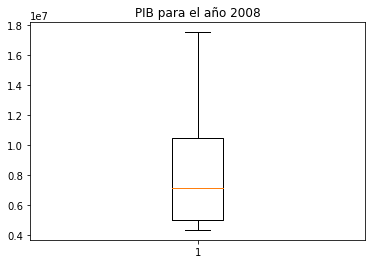

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('PIB para el año 2008')
ax1.boxplot(np.array(pib.select('2008').collect()))

Acá se logra apreciar que el 75% de los datos muestra un valor de PIB alrededor de el 1.0e7 y se registra un valor atípico de PIB superior a 1.7e7

#### 2010

{'whiskers': [<matplotlib.lines.Line2D at 0x1c2d7516b48>,
 'caps': [<matplotlib.lines.Line2D at 0x1c2d752aa88>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c2d7530508>],
 'medians': [<matplotlib.lines.Line2D at 0x1c2d753d2c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c2d7538cc8>],
 'means': []}

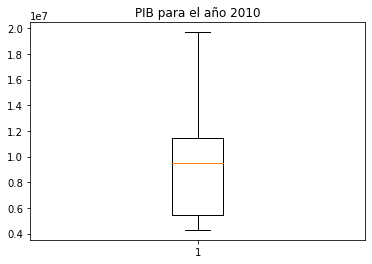

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('PIB para el año 2010')
ax1.boxplot(np.array(pib.select('2010').collect()))

Acá se logra apreciar que el 75% de los datos muestra un valor de PIB alrededor de el 1.1e7 y se registra un valor atípico de PIB superior a 1.9e7

#### 2011

{'whiskers': [<matplotlib.lines.Line2D at 0x1c2d75b43c8>,
 'caps': [<matplotlib.lines.Line2D at 0x1c2d75b4fc8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c2d75b4d88>],
 'medians': [<matplotlib.lines.Line2D at 0x1c2d75bc7c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c2d75bce88>],
 'means': []}

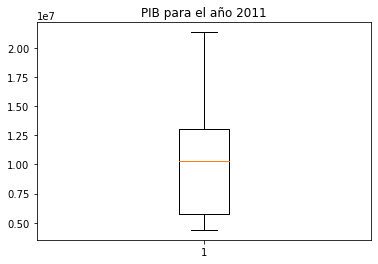

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('PIB para el año 2011')
ax1.boxplot(np.array(pib.select('2011').collect()))

Acá se logra apreciar que el 75% de los datos muestra un valor de PIB alrededor de el 1.25e7 y se registra un valor atípico de PIB superior a 2.0e7

#### 2012

{'whiskers': [<matplotlib.lines.Line2D at 0x1c2d762c648>,
 'caps': [<matplotlib.lines.Line2D at 0x1c2d7631cc8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c2d762cf08>],
 'medians': [<matplotlib.lines.Line2D at 0x1c2d7637908>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c2d7637fc8>],
 'means': []}

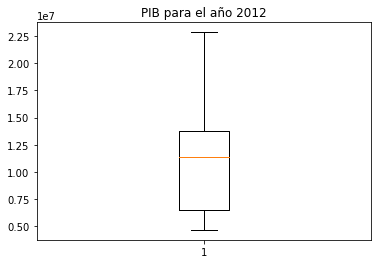

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('PIB para el año 2012')
ax1.boxplot(np.array(pib.select('2012').collect()))

Acá se logra apreciar que el 75% de los datos muestra un valor de PIB alrededor de el 1.3e7 y se registra un valor atípico de PIB superior a 2.25e7

#### 2013

{'whiskers': [<matplotlib.lines.Line2D at 0x1c2d76aa548>,
 'caps': [<matplotlib.lines.Line2D at 0x1c2d76b0d88>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c2d76aafc8>],
 'medians': [<matplotlib.lines.Line2D at 0x1c2d76b4988>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c2d76b4888>],
 'means': []}

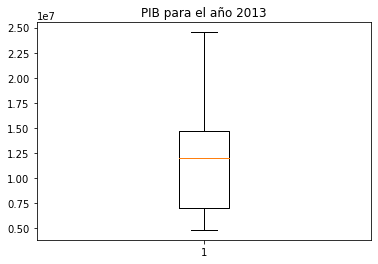

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('PIB para el año 2013')
ax1.boxplot(np.array(pib.select('2013').collect()))

Acá se logra apreciar que el 75% de los datos muestra un valor de PIB alrededor de el 1.5e7 y se registra un valor atípico de PIB superior a 2.3e7

#### 2014

{'whiskers': [<matplotlib.lines.Line2D at 0x1c2d772fa88>,
 'caps': [<matplotlib.lines.Line2D at 0x1c2d7734608>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c2d772f9c8>],
 'medians': [<matplotlib.lines.Line2D at 0x1c2d7739408>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c2d7734dc8>],
 'means': []}

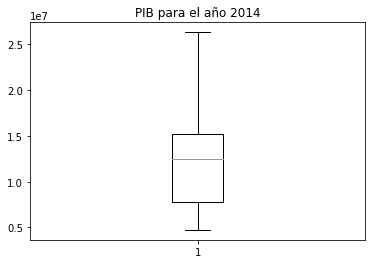

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('PIB para el año 2014')
ax1.boxplot(np.array(pib.select('2014').collect()))

Acá se logra apreciar que el 75% de los datos muestra un valor de PIB alrededor de el 1.5e7 y se registra un valor atípico de PIB superior a 2.5e7

### Análisis de calidad de datos

Para evaluar la calidad de los datos, se determinará la idoneidad de la dimensión de completitud, unicidad, consistencia y validez.

#### Unicidad

La unicidad se revisó en la regla de negocio <i>Hay informacion del PIB para los 32 departamentos desde 2005 hasta 2018</i> y en la regla de negocio <i>Hay información de 7879 centros poblados</i> en donde se hace énfasis en la duplicidad de información en los registros. La unicidad también se ve reflejada cuando se utiliza la herramienta Pandas Profiling en una sección posterior.

#### Completitud
El código tomado a continuación es adaptado del tutorial y me pareció valiosa la implementación para evaluar la completitud y validez de la información ya que los métodos se adaptan a el dataframe que se pasa por parámetro sin tener que modificar los métodos.

In [38]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [40]:
contar_vacios(pib)

[]

In [41]:
contar_vacios(divipola)

[]

Como se ve en el resultado, a pesar de que todas las columnas en la tabla divipolaCopia pueden almacenar valores nulos, no hay ninguna columna que tenga como valor un null, pero esto no es precisamente algo bueno ya que si en la columna `Nombre Área Metropolitana` y en la columna `Nombre Distrito`  si bien no hay nulos, hay campos con cadenas vacías

In [45]:
divipola.filter(col("Nombre Área Metropolitana")=='').count()

9028

In [46]:
divipola.filter(col("Nombre Distrito")=='').count()

9134

Como se puede observar, existen 9028 centros poblados con un nombre de área metropolitana vacío y 9134 centros poblados con Nombres de distrito vacíos, vale la pena recordar que el total de centros poblados son 9508, por lo que es una cantidad considerable de registros con información vacía que vale la pena preguntar a negocio sobre la importancia de estos.

In [47]:
cardinalidad(pib)

{'CodigoDepartamento(DIVIPOLA)': 17,
 'DEPARTAMENTOS': 17,
 '2006': 17,
 '2007': 17,
 '2008': 17,
 '2010': 17,
 '2011': 17,
 '2012': 17,
 '2013': 17,
 '2014': 17}

In [48]:
cardinalidad(divipola)

{'Código Centro Poblado': 7879,
 'Nombre Centro Poblado': 5512,
 'Longitud': 7078,
 'Latitud': 7079}

Para la tabla **PIBCopia**, todas las columnas tienen una cardinalidad superior al 50% con respecto del total de departamentos con registros de PIB.<br>
Para la tabla **divipolaCopia** las columnas Código Centro Poblado, Nombre Centro Poblad, Longitud y Latitud tienen una cardinalidad superior al 50% con respecto del total de registros con centros poblados.

Por otra parte, como se mencionó en la regla de negocio 1 <i>Hay informacion del PIB para los 32 departamentos desde 2005 hasta 2018</i>, hacen falta departamentos y años para tener el PIB por departamento

#### Consistencia
Para determinar la consistencia de la tabla, se procede a evaluar la columna `Código Departamento`

In [49]:
divipola.select(col('Código Departamento')).distinct().show()

+-------------------+
|Código Departamento|
+-------------------+
|                 41|
+-------------------+



Se puede observar que solo existe el código de departamento 41 para todos los centros poblados, esto daría a entender que solo hay registros para un departamento, sin embargo, esto no es correcto ya que el código de departamento 41 está representando a varios departamentos como se muestra a continuación

In [51]:
divipola.groupBy("Código Departamento", "Nombre Departamento").count().show()

+-------------------+--------------------+-----+
|Código Departamento| Nombre Departamento|count|
+-------------------+--------------------+-----+
|                 41|              caldas|   52|
|                 41|              vaupes|    3|
|                 41|archipielago de s...|   14|
|                 41|                uila|  191|
|                 41|           santander|   97|
|                 41|           ATLANTICO|   81|
|                 41|               amazX|   55|
|                 41|           risaralda|   43|
|                 41|           vaupeszsx|   14|
|                 41|              GUANIA|   17|
|                 41|             CAQUETA|   99|
|                 41|                META|  178|
|                 41|           antioquia|  192|
|                 41|            VASANARE|   92|
|                 41|              boyaca|   63|
|                 41|        cundinamarca|  125|
|                 41|               cauca|  118|
|                 41

Acá podemos ver que por ejemplo, el código de departamento 41 está representando al departamento caldas 52 veces y a vaupes lo está representando 3 veces, esto no guarda consistencia con la tabla PIBCopia, la cual tiene un nombre en específico para el código de departamento 41

In [58]:
pib.filter(col("CodigoDepartamento(DIVIPOLA)") == 41).limit(1).show()

+----------------------------+-------------+-------+-------+-----------------+----------------+--------+--------+--------------------+--------+
|CodigoDepartamento(DIVIPOLA)|DEPARTAMENTOS|   2006|   2007|             2008|            2010|    2011|    2012|                2013|    2014|
+----------------------------+-------------+-------+-------+-----------------+----------------+--------+--------+--------------------+--------+
|                          41|         uila|6895658|7441987|8686536.103258422|9548624.85406653|11113741|11400169|1.1967750469189592E7|12755711|
+----------------------------+-------------+-------+-------+-----------------+----------------+--------+--------+--------------------+--------+



En el resultado anterior se puede observar que para el código de departamento 41, el nombre del departamento que representa este código es uila (Está mal escrito)

Como se mencionó en la sección que muestra los esquemas de las tablas, en divipolaCopia se puede observar que el tipo de dato del campo Código Departamento es IntegerType y para el campo de la tabla pibCopia es LongType, estos tipos de datos no son consistentes entre las dos tablas.

Es importante resaltar que los nombres de las columnas provistos en el diccionario de datos para la tabla divipolaCopia no son acordes a los que están en la fuente de datos provista, en la fuente de datos los nombres de las columnas contienen espacios y tíldes, en el diccionario no.

#### Validez
Se procede a verificar si los datos proporcionados son válidos.

Se analizará la información almacenada en la columna DEPARTAMENTOS de la tabla PIBCopia  

In [60]:
pib.select("DEPARTAMENTOS").distinct().show()

+--------------------+
|       DEPARTAMENTOS|
+--------------------+
|            CaquetÃ¡|
|          AtlÃ¡ntico|
|             VICHADA|
|            guaviare|
|             cordoba|
|           ANTIOQUIA|
|            norte de|
|            QuindiÃ³|
|                uila|
|              GUANIA|
|            el valle|
|Republica de Colo...|
|boyacaaaaaaaaaaaa...|
|             NARIÃ‘O|
|            El Cesar|
|            PUTUMAYO|
|Bogota distrito c...|
+--------------------+



Como se puede ver, hay nombres mal escritos para los departamentos de colombia, como boyacaaaaaaaaaaaaaaaaaaaa, norte de, uila y el valle, además, se puso como departamento a Republica de Colombia, estos datos son incorrectos

## Herramientas para facilitar el entendimiento de datos

Se hará uso de la herramienta Pandas Profiling para mostrar gráficos y estadísticos relacionados a la tabla divipolaCopia

In [61]:
reporte = ProfileReport(divipola.toPandas())
reporte.to_file(PATH+"reporte_prefilamiento.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 59.75it/s]


El reporte nos muestra varias secciones las cuales se detallarán a continuación.

**Seccion general del reporte:**
1. Tenemos 12 variables y 9508 registros de centros poblados, 4 variables son numéricas y 8 categóricas
2. En total la herramienta muestra que hay 0% de datos faltantes, sin embargo, como se mencionó anteriormente, si bien no hay valores nulos, las columnas Área Metropolitana o Nombre Distrito al ser de tipo String almacenan cadenas vacías.
3. El archivo ocupa en memoria 780KB
4. Se muestra que existe un 0% de registros duplicados, esto es porque las filas tienen valores diferentes en las columnas, pero como anteriormente se mencionó, el campo de Código Centro Poblado que es el identificador de la tabla si tiene duplicados.

**Sección de variables del reporte:**

5. La variable Código Municipio tiene 1121 registros distintos, lo que equivale al 11.8% de registros, se tiene un código mínimo de 5001 y uno máximo de 99773.

6. Para la variable Código Departamento se puede ver que hay menos del 0.1% de valores distintos, esto es porque el único código de departamento que aparece es el 41 y este está para los 9508 centros poblados.
7. Para la variable Código Centro Poblado se puede observar que existen 7879 datos diferentes, lo cual equivale al 82.9% de registros, el valor mínimo es de 5001000 y el máximo es de 99773027
8. La variable Nombre Departamento refleja información importante, en donde la mayoría de centros poblados están en el departamento de ANTIOQUIA, con una cantidad de 734, existen 64 valores distintos para el campo, lo cual es extraño ya que en Colombia hay 32 departamentos.
9. Se puede apreciar que la variable Nombre Municipio solo tiene un valor distinto, lo cual indica que solo se consideró el nombre de un municipio para los centros poblados, este municipio es NEIVA y se debería mencionar este descubriiento a negocio dado que existen nombres de departamentos, como ANTIOQUIA que no se corresponden con el municipio.
10. En la variable Nombre Centro Poblado existen 5512 valores diferentes, esto significa que el 58% de los centros poblados son diferentes, además, PUEBLO NUEVO es el valor que está más presente en el campo con 51 registros.
11. En la variable Tipo Centro Poblado solo hay dos valores diferentes, que corresponden a los valores CENTRO POBLADO el cual aparece en 8169 registros y CABECERA MUNICIPAL.
12. En la variable Longitud existen 7078 valores diferentes, el valor mínimo es -81.7300009 y el máximo es 0.
13. En la variable Latitud existen 7079 valores diferentes, el valor mínimo es -4.194698789 y el máximo es 13.38396922.
14. En la variable Nombre Distrito solo existen 10 valores diferentes, y se puede apreciar que 9134 valores están vacíos, como ya se había mencionado previamente
15. En la variable Municipio/Áreas No Municipalizadas (ANM) solo existen 3 valores diferentes, el valor MUNICIPIO es el que están en mayor cantidad de centros poblados, con un total de 9476 registros.
16. En la variable Nombre Área Metropolitana solo existen 7 valores diferentes, acá se puede observar que la mayoría de registros contienen campos vacíos, con un total de 9028.

**Sección de interacciones y correlaciones:**

En la tabla divipolaCopia no hay columnas con correlaciones iguales a 1, por lo que no hay columnas que representen la misma información, las columnas que guardan mayor relación son Longitud y Latitud, pero esto puede ser normal dado la naturaleza de los valores que almacenan.

### Conclusiones

**Conclusiones generales:**

1. En la tabla de PIBCopia, se puede observar que en los registros tenemos información relacionada al **código del departamento** (que guarda relación con la tabla divipolaCopia), **departamentos**, y el **PIB para los años 2006, 2007, 2008, 2010, 2011, 2012, 2013 y 2014**.
2. En la tabla de divipolaCopia, se puede evidenciar que el identificador de la tabla es  **Código Centro Poblado**, también se presenta información asociada al municipio en las columas **Código Municipio y Nombre Municipio**, se muestra información más específica para la localización como la **Longitud y la Latitud**, el **tipo de centro poblado**, el **nombre del distrito** y el **área metropolitana**.
3. Una fila de la tabla PIBCopia corresponde al PIB por departamento en un año en específico.
4. Una fila de la tabla divipolaCopia corresponde a la información de centros poblados que están relacionados con un departamento y ciudad, además, relaciona información de ubicación más específica como la longitud y latitud.

**Conclusiones de reglas de negocio:**

1. Existe registro del PIB por departamento solo para 17 departamentos, que corresponde a casi la mitad de lo que indica la regla de negocio, por lo que es necesario pedirle una aclaración al negocio sobre la falta de departamentos
2. No existe información del PIB para el año 2005, 2009, 2015, 2016, 2017 y 2018, lo cual corresponde a casi el 43% de años faltantes, es una cantidad considerable así que es indispensable corroborar la información con negocio
3. Se tienen 1629 registros que representan el mismo centro poblado pero con valores diferentes

**Conclusiones de calidad:**

1. Existen 9028 centros poblados con un nombre de área metropolitana vacío y 9134 centros poblados con Nombres de distrito vacíos, son cifras bastante altas, por lo que es importante preguntar al negocio sobre la importancia de estos campos.
2. Para la tabla **PIBCopia**, todas las columnas tienen una cardinalidad superior al 50% con respecto del total de departamentos con registros de PIB.
3. Para la tabla **divipolaCopia** las columnas Código Centro Poblado, Nombre Centro Poblad, Longitud y Latitud tienen una cardinalidad superior al 50% con respecto del total de registros con centros poblados.
4. En la tabla divipolaCopia solo existe el código de departamento 41, este debería representar a un departamento en particular, pero está representando a muchos departamentos, lo cual no parece correcto y es importante recibir aclaraciones por parte del negocio.
5. En la tabla divipolaCopia se puede observar que el tipo de dato del campo Código Departamento es IntegerType y para el campo de la tabla PIBCopia es LongType, estos tipos de datos no son consistentes entre las dos tablas.
6. Los nombres de las columnas provistos en el diccionario de datos para la tabla divipolaCopia no son acordes a los que están en la fuente de datos provista, en la fuente de datos los nombres de las columnas contienen espacios y tíldes, en el diccionario no. ¿Se deben cambiar los nombres de las columnas para la tabla divipolaCopia?
7. Hay nombres mal escritos para los departamentos de colombia, como boyacaaaaaaaaaaaaaaaaaaaa, norte de, uila y el valle, además, se puso como departamento a Republica de Colombia, estos datos son incorrectos.

**Usando herramientas:**

Seccion general del reporte:
1. Tenemos 12 variables y 9508 registros de centros poblados, 4 variables son numéricas y 8 categóricas
2. En total la herramienta muestra que hay 0% de datos faltantes, sin embargo, como se mencionó anteriormente, si bien no hay valores nulos, las columnas Área Metropolitana o Nombre Distrito al ser de tipo String almacenan cadenas vacías.
3. El archivo ocupa en memoria 780KB
4. Se muestra que existe un 0% de registros duplicados, esto es porque las filas tienen valores diferentes en las columnas, pero como anteriormente se mencionó, el campo de Código Centro Poblado que es el identificador de la tabla si tiene duplicados.

Sección de variables del reporte:

5. La variable Código Municipio tiene 1121 registros distintos, lo que equivale al 11.8% de registros, se tiene un código mínimo de 5001 y uno máximo de 99773.

6. Para la variable Código Departamento se puede ver que hay menos del 0.1% de valores distintos, esto es porque el único código de departamento que aparece es el 41 y este está para los 9508 centros poblados.
7. Para la variable Código Centro Poblado se puede observar que existen 7879 datos diferentes, lo cual equivale al 82.9% de registros, el valor mínimo es de 5001000 y el máximo es de 99773027
8. La variable Nombre Departamento refleja información importante, en donde la mayoría de centros poblados están en el departamento de ANTIOQUIA, con una cantidad de 734, existen 64 valores distintos para el campo, lo cual es extraño ya que en Colombia hay 32 departamentos.
9. Se puede apreciar que la variable Nombre Municipio solo tiene un valor distinto, lo cual indica que solo se consideró el nombre de un municipio para los centros poblados, este municipio es NEIVA y se debería mencionar este descubriiento a negocio dado que existen nombres de departamentos, como ANTIOQUIA que no se corresponden con el municipio.
10. En la variable Nombre Centro Poblado existen 5512 valores diferentes, esto significa que el 58% de los centros poblados son diferentes, además, PUEBLO NUEVO es el valor que está más presente en el campo con 51 registros.
11. En la variable Tipo Centro Poblado solo hay dos valores diferentes, que corresponden a los valores CENTRO POBLADO el cual aparece en 8169 registros y CABECERA MUNICIPAL.
12. En la variable Longitud existen 7078 valores diferentes, el valor mínimo es -81.7300009 y el máximo es 0.
13. En la variable Latitud existen 7079 valores diferentes, el valor mínimo es -4.194698789 y el máximo es 13.38396922.
14. En la variable Nombre Distrito solo existen 10 valores diferentes, y se puede apreciar que 9134 valores están vacíos, como ya se había mencionado previamente
15. En la variable Municipio/Áreas No Municipalizadas (ANM) solo existen 3 valores diferentes, el valor MUNICIPIO es el que están en mayor cantidad de centros poblados, con un total de 9476 registros.
16. En la variable Nombre Área Metropolitana solo existen 7 valores diferentes, acá se puede observar que la mayoría de registros contienen campos vacíos, con un total de 9028.

Sección de interacciones y correlaciones:

17. En la tabla divipolaCopia no hay columnas con correlaciones iguales a 1, por lo que no hay columnas que representen la misma información, las columnas que guardan mayor relación son Longitud y Latitud, pero esto puede ser normal dado la naturaleza de los valores que almacenan.

**Conclusiones de consultoria**

![Requerimiento](./requerimiento_proyecto.png)
<br>**NOTA**: La imagen del requerimiento se encuentra dentro de la carpeta <i>Trabajo Semana 4</i> con el nombre requerimiento_proyecto.png

Teniendo en cuenta el requerimiento de WWI, la diferencia con respecto a la cantidad de departamentos y años donde se registra el PIB para cada departamente es considerable, además el código del departamente en la tabla divipolaCopia siempre es el mismo, aún así, asignar el código del departamento puede no tomar mucho tiempo, sin embargo, resulta de vital importancia tener la completitud de los departamentos y hacer los respectivos ajustes a sus nombres para poder distinguir bien la información y filtrarla y dado que en el requerimiento en el análisis 5 y 6 se hace mención del PIB y de los centros poblados, el PIB se obtendría de forma incompleta por departamento, además, en el análisis 5 el departamento con mayor promedio podría no estar relacionado con algún departamento de la tabla PIBCopia, lo cual no se podría obtener el PIB para un año en particular, por lo que como están los datos, no sería viable cumplir con el requerimiento.

### Lista de preguntas o comentarios realizados a la organización
En las conclusiones y a lo largo del notebook se han hecho preguntas y comentarios a la organización, pero en este apartado se sintetizarán:
1. ¿Por qué existen solo 17 registros de departamentos con la información de PIB? ¿Esta información será completada?
2. No existe información del PIB para el año 2005, 2009, 2015, 2016, 2017 y 2018 ¿Se agregará la información de PIB para estos años?
3. Existen 9028 centros poblados con un nombre de área metropolitana vacío y 9134 centros poblados con Nombres de distrito vacíos ¿La información de estos campos se puede eliminar?
4. En la tabla divipolaCopia solo existe el código de departamento 41, ¿Por qué solo existe este código? ¿Cada departamento debería tener un código único? el código 41 se está relacionando con varios nombres de departamentos diferentes.
5. ¿Se deben cambiar los nombres de las columnas para la tabla divipolaCopia para que queden igual al de diccionario de datos suministrado?
6. Hay nombres mal escritos para los departamentos de colombia, como boyacaaaaaaaaaaaaaaaaaaaa, norte de, uila y el valle, esta información se debería corregir para facilitar los análisis.
7. El nombre de nunicipio en la tabla divipolaCopia siempre es NEIVA ¿Esto está bien?